# Satellite Data Acquisition - Quick Start: Single Image Download

Simple example to download a single satellite image and visualize it.

Author: Peter Kongstad

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, configure_logging
from sat_data_acquisition.processing import save_geotiff
from sat_data_acquisition.config.settings import SatDataSettings

In [2]:
# Configure logging
configure_logging(verbose=False)

## Define Area of Interest

Create a bounding box around Copenhagen.

In [3]:
# Define area as bounding box (rectangular shape)
copenhagen_center = Point(12.5683, 55.6761)  # lon, lat
buffer = 0.024  # ~5 km

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area bounds: {geometry.bounds}")
print(f"Approximate area: {(buffer * 111 * 2)**2:.1f} km²")

Area bounds: (12.544300000000002, 55.6521, 12.5923, 55.7001)
Approximate area: 28.4 km²


## Download Image

Search for a recent Sentinel-2 image with low cloud coverage.

In [4]:
# Initialize client
client = SatDataClient()
settings = SatDataSettings()

# Configure search parameters
processing_params = ProcessingParams(
    satellite="S2E84",
    search_method="geometry",
    bands=["red", "green", "blue"],  # RGB for true color visualization
    start_date="2024-06-01",
    end_date="2024-06-30",
    cloud_coverage=20,  # Max 20% cloud coverage
)

print(f"Searching for images: {processing_params.start_date} to {processing_params.end_date}")
print(f"Bands: {processing_params.bands}")
print(f"Max cloud coverage: {processing_params.cloud_coverage}%")

Searching for images: 2024-06-01 to 2024-06-30
Bands: ['red', 'green', 'blue']
Max cloud coverage: 20%


In [5]:
# Download image
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
)

print(f"\nFound {len(dataset.time)} image(s)")
if len(dataset.time) > 0:
    date_str = str(dataset.time.values[0])[:10]
    print(f"Using image from: {date_str}")

INFO - Found 1 items for S2E84 matching the search query.



Found 1 image(s)
Using image from: 2024-06-02


## Visualize True Color Image (TCI)

Display the RGB bands as a true color composite.

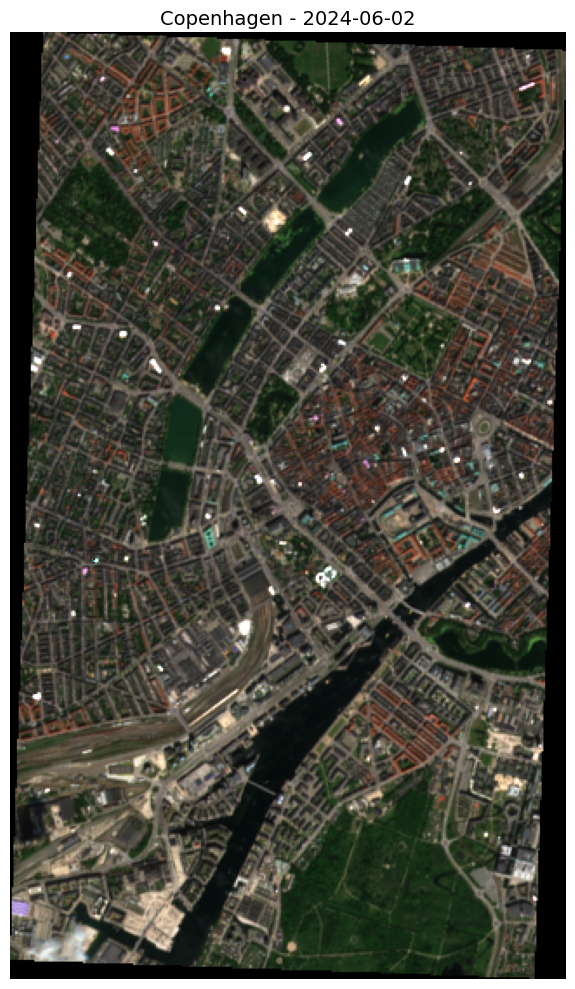

Image shape: (545, 320, 3)
Pixel resolution: (10.0, -10.0)


In [6]:
if len(dataset.time) > 0:
    # Get first time step
    image_slice = dataset.sel(time=dataset.time.values[0])
    date_str = str(dataset.time.values[0])[:10]
    
    # Extract RGB bands and scale for display
    rgb = image_slice.to_array().values[:3].transpose(1, 2, 0)
    rgb_scaled = np.clip(rgb / 3000, 0, 1)  # Scale to 0-1 range
    
    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_scaled)
    plt.title(f"Copenhagen - {date_str}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Image shape: {rgb.shape}")
    print(f"Pixel resolution: {image_slice.rio.resolution()}")
else:
    print("No images found for the specified criteria")

## Save Image to Disk

Save the downloaded image as a GeoTIFF file.

In [7]:
if len(dataset.time) > 0:
    # Save to GeoTIFF
    save_geotiff(
        image=image_slice,
        identifier="copenhagen",  # Area name for filename
        datetime=date_str,
        satellite=processing_params.satellite,
        provider="E84",
        output_path="../data/images",
        save_to_local=True,
        identifier_type="area_name",
        enable_compression=True,
        settings=settings,
    )
    
    print(f"Image saved to: ../data/images/S2E84/{date_str[:4]}/tiff/")
    print(f"Filename: S2E84_{date_str}_red_green_blue_copenhagen.tif")

Image saved to: ../data/images/S2E84/2024/tiff/
Filename: S2E84_2024-06-02_red_green_blue_copenhagen.tif
